In [15]:
# 1) Imports and plot styling
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import Pk_library as PKL

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = '~/cosmo_compression/models/8_ch_model.ckpt'   # ← change to your .ckpt
dataset_path = '/monolith/global_data/astro_compression/CAMELS/'

In [16]:
# 2) Device and model setup
from cosmo_compression.data import data
from cosmo_compression.model import represent

torch.manual_seed(42)
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Map settings
MAP_TYPE = 'Mcdm'
MAP_RESOLUTION = 256
mean = data.NORM_DICT[MAP_TYPE][MAP_RESOLUTION]['mean']
std  = data.NORM_DICT[MAP_TYPE][MAP_RESOLUTION]['std']

# Load pretrained model
fm = represent.CosmoFlow.load_from_checkpoint(model_ckpt).to(device)
fm.eval()

CosmoFlow(
  (encoder): ResNetEncoder(
    (resnet_list): ModuleList(
      (0): ResNet(
        (in_layer): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (resnet_layers): ModuleList(
          (0-1): 2 x Sequential(
            (0): ResnetBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [17]:
# 3) Load dataset and select samples
dataset = data.CAMELS(
    root=dataset_path,
    map_type=MAP_TYPE,
    dataset='1P',
    parameters=['Omega_m','sigma_8','A_SN1','A_SN2','A_AGN1','A_AGN2','Omega_b'],
)

# original and target
img0, _ = dataset[1]
img1, _ = dataset[61]
# bring to device
img0 = torch.tensor(img0).unsqueeze(0).to(device)
img1 = torch.tensor(img1).unsqueeze(0).to(device)

In [18]:
# 4) Encode and compute input P(k)
# Encode
h0 = fm.encoder(img0)
h1 = fm.encoder(img1)

# Un-normalize for plotting
img0_np = img0.cpu().numpy()[0,0] * std + mean
img1_np = img1.cpu().numpy()[0,0] * std + mean

# Compute P(k)
delta0 = img0_np/np.mean(img0_np) - 1
delta1 = img1_np/np.mean(img1_np) - 1
pk0 = PKL.Pk_plane(delta0, 25.0, 'None', 1, verbose=False)
pk1 = PKL.Pk_plane(delta1, 25.0, 'None', 1, verbose=False)
k0, Pk0 = pk0.k, pk0.Pk
k1, Pk1 = pk1.k, pk1.Pk

In [ ]:
# 5) Modulation-stage latent swaps
# Channels to interpolate in the example are detenmined for the 8-channel model.

modulation_ranges = {
    'High Frequency': list(range(0,2)),
    'Low Frequency':  list(range(2,8)),
}

n_samples = 40
x0 = torch.randn((1,1,MAP_RESOLUTION,MAP_RESOLUTION), device=device)

intermediate = []
for label, chans in modulation_ranges.items():
    h_mod = h0.clone()
    h_mod[:,chans,:,:] = h1[:,chans,:,:]
    with torch.no_grad():
        decoded = fm.decoder.predict(x0, h=h_mod, n_sampling_steps=n_samples)
    img_mod = decoded.cpu().numpy()[0,0]*std + mean
    pk2 = PKL.Pk_plane(img_mod/np.mean(img_mod)-1, 25.0, 'None', 1, verbose=False)
    intermediate.append((label, img_mod, pk2.k, pk2.Pk))

/tmp/ipykernel_3841759/2330259023.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axpk.legend()
/tmp/ipykernel_3841759/2330259023.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axfpk.legend()


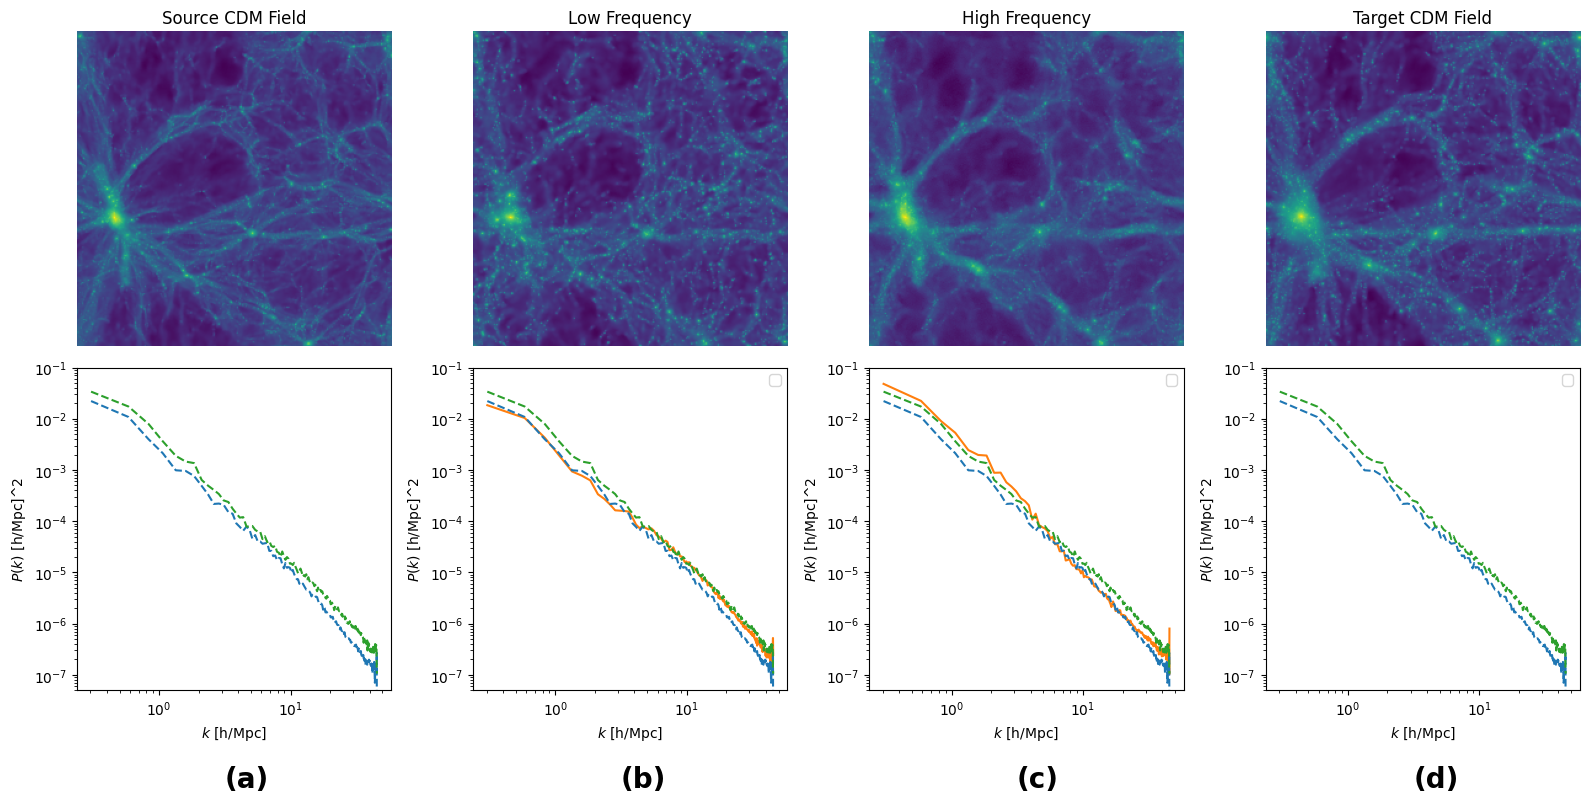

In [20]:
# 6) Plot multi-column grid
n_int = len(intermediate)
n_cols = n_int + 2
fig, axs = plt.subplots(2, n_cols, figsize=(4*n_cols, 8))

colors = {'orig':'C0','recon':'C1','targ':'C2'}
lw = 1.5
labels = ['(a)','(b)','(c)','(d)']

# Original
axs[0,0].imshow(img0_np, cmap='viridis', origin='lower')
axs[0,0].set_title('Source CDM Field'); axs[0,0].axis('off')
ax0pk = axs[1,0]
ax0pk.plot(k0, Pk0, '--', color=colors['orig'], lw=lw)
ax0pk.plot(k1, Pk1, '--', color=colors['targ'], lw=lw)
ax0pk.set(xscale='log', yscale='log', xlabel='$k$ [h/Mpc]', ylabel='$P(k)$ [h/Mpc]^2', ylim=(5e-8,1e-1))
ax0pk.text(0.47,-0.3,labels[0], transform=axs[1,0].transAxes, fontsize=20, fontweight='bold')

# Intermediates
for i,(lab, img_mod, k_mod, Pk_mod) in enumerate(intermediate):
    c = i+1
    axs[0,c].imshow(img_mod, cmap='viridis', origin='lower')
    axs[0,c].set_title(lab); axs[0,c].axis('off')
    axpk = axs[1,c]
    axpk.plot(k_mod, Pk_mod, color=colors['recon'], lw=lw)
    axpk.plot(k0, Pk0, '--', color=colors['orig'], lw=lw)
    axpk.plot(k1, Pk1, '--', color=colors['targ'], lw=lw)
    axpk.set(xscale='log', yscale='log', xlabel='$k$ [h/Mpc]', ylabel='$P(k)$ [h/Mpc]^2', ylim=(5e-8,1e-1))
    axpk.text(0.47,-0.3,labels[c], transform=axs[1,c].transAxes, fontsize=20, fontweight='bold')
    axpk.legend()

# Final
fcol = n_cols-1
axs[0,fcol].imshow(img1_np, cmap='viridis', origin='lower')
axs[0,fcol].set_title('Target CDM Field'); axs[0,fcol].axis('off')
axfpk = axs[1,fcol]
axfpk.plot(k0, Pk0, '--', color=colors['orig'], lw=lw)
axfpk.plot(k1, Pk1, '--', color=colors['targ'], lw=lw)
axfpk.set(xscale='log', yscale='log', xlabel='$k$ [h/Mpc]', ylabel='$P(k)$ [h/Mpc]^2', ylim=(5e-8,1e-1))
axfpk.text(0.47,-0.3,labels[fcol], transform=axs[1,fcol].transAxes, fontsize=20, fontweight='bold')
axfpk.legend()

plt.tight_layout()
plt.show()